In [8]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# --- user editable parameters ---
SYMBOL       = "btc_usdc"      # change if your file is btc_usdt, etc.
INTERVAL     = "1h"            # 1m / 15m / 1h / 1d ...
START_DATE   = "2025-04-25"            # e.g. "2024-05-03"
END_DATE     = "2025-05-02"            # e.g. "2025-05-03"
ROWS_LIMIT   = None            # e.g. 10000 to display last N rows

# --------------------------------
DATA_DIR = Path("..") / "data"
TA_FILE  = DATA_DIR / f"{SYMBOL}_{INTERVAL}_ta.parquet"

df = pd.read_parquet(TA_FILE)
df['open_dt'] = pd.to_datetime(df['open_time'], unit='ms', utc=True)
print(f"Loaded {len(df):,} rows from {TA_FILE}")

if START_DATE:
    start_ts = pd.to_datetime(START_DATE, utc=True)
    df = df[df.open_dt >= start_ts]
if END_DATE:
    end_ts = pd.to_datetime(END_DATE, utc=True)
    df = df[df.open_dt <= end_ts]
if ROWS_LIMIT:
    df = df.tail(ROWS_LIMIT)

print(f"Plotting {len(df):,} rows from {df.open_dt.min()} to {df.open_dt.max()}")

Loaded 8,711 rows from ../data/btc_usdc_1h_ta.parquet
Plotting 169 rows from 2025-04-25 00:00:00+00:00 to 2025-05-02 00:00:00+00:00


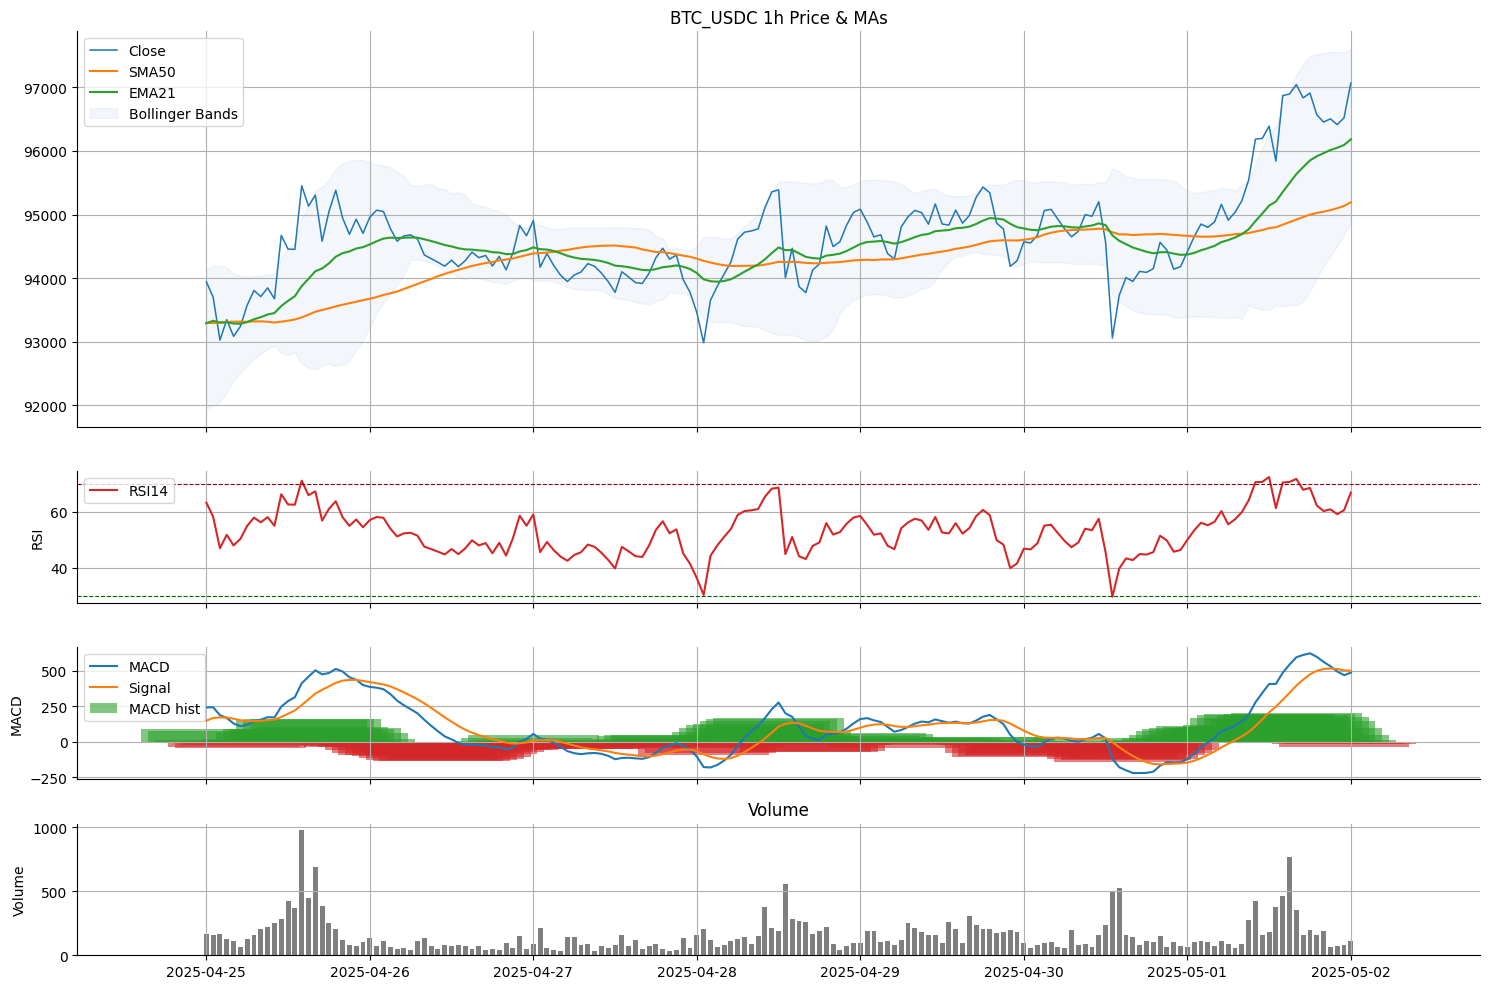

In [9]:
plt.style.use('default')
plt.rcParams.update({
    'figure.figsize': (15, 10),
    'axes.grid': True,
    'axes.spines.top': False,
    'axes.spines.right': False,
})

fig, axes = plt.subplots(4, 1, sharex=True, gridspec_kw={'height_ratios':[3,1,1,1]})

# --- Price & Moving Averages + Bollinger ---
ax_price = axes[0]
ax_price.plot(df['open_dt'], df['close'], label='Close', color='#1f77b4', lw=1.1)
if 'sma50' in df.columns:
    ax_price.plot(df['open_dt'], df['sma50'], label='SMA50', color='#ff7f0e')
if 'ema21' in df.columns:
    ax_price.plot(df['open_dt'], df['ema21'], label='EMA21', color='#2ca02c')
if 'BBL_20_2.0' in df.columns:
    ax_price.fill_between(df['open_dt'], df['BBL_20_2.0'], df['BBU_20_2.0'],
                          alpha=0.15, color='#b0c4de', label='Bollinger Bands')
ax_price.set_title(f"{SYMBOL.upper()} {INTERVAL} Price & MAs")
ax_price.legend(loc='upper left')

# --- RSI ---
ax_rsi = axes[1]
if 'rsi14' in df.columns:
    ax_rsi.plot(df['open_dt'], df['rsi14'], color='#d62728', label='RSI14')
    ax_rsi.axhline(70, ls='--', lw=0.8, color='#8b0000')
    ax_rsi.axhline(30, ls='--', lw=0.8, color='#006400')
    ax_rsi.set_ylabel('RSI')
    ax_rsi.legend(loc='upper left')
else:
    ax_rsi.text(0.5,0.5,'RSI not in dataset', ha='center', va='center')

# --- MACD ---
ax_macd = axes[2]
if 'MACD_12_26_9' in df.columns:
    colors = ['#2ca02c' if v>=0 else '#d62728' for v in df['MACDh_12_26_9']]
    ax_macd.bar(df['open_dt'], df['MACDh_12_26_9'], color=colors, alpha=0.6, label='MACD hist')
    ax_macd.plot(df['open_dt'], df['MACD_12_26_9'], color='#1f77b4', label='MACD')
    ax_macd.plot(df['open_dt'], df['MACDs_12_26_9'], color='#ff7f0e', label='Signal')
    ax_macd.set_ylabel('MACD')
    ax_macd.legend(loc='upper left')
else:
    ax_macd.text(0.5,0.5,'MACD not in dataset', ha='center', va='center')

# --- Volume ---
ax_vol = axes[3]
ax_vol.bar(df['open_dt'], df['volume'], width=0.03, color='#7f7f7f')
ax_vol.set_ylabel('Volume')
ax_vol.set_title('Volume')

plt.tight_layout()
plt.show()
